In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

from data_loading import (load_m1h_activation_data,
                          load_annotated_TFiso1_collection)

In [2]:
tfs = load_annotated_TFiso1_collection()
m1h = load_m1h_activation_data()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
m1h['iso_acc'] = m1h['clone_acc'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

# get genes with KRAB domains
KRAB_PFAM_AC = 'PF01352'
df = pd.concat([g.aa_feature_disruption(g.isoforms[0].name) for g in tfs.values()])

df = df.loc[df['accession'] == KRAB_PFAM_AC, :]
df = df.groupby(['gene_symbol', 'ref_iso', 'alt_iso', 'accession']).sum().reset_index()

df['n_aa_diff'] = df.apply(lambda x: len(tfs[x['gene_symbol']][x['ref_iso']].aa_seq) - len(tfs[x['gene_symbol']][x['alt_iso']].aa_seq), axis=1)
print((df['n_aa_diff'] < 1).sum(), 'n_aa_diff < 1')
# HACK
df['n_aa_diff'] = df['n_aa_diff'].abs()

df['is_affected'] = df[['deletion', 'insertion', 'frameshift']].sum(axis=1) > 0
df['complete_removal'] = (df['deletion'] == df['length'])
df['m1h_ref'] = df['ref_iso'].map(m1h.set_index('iso_acc')['mean'])
df['m1h_alt'] = df['alt_iso'].map(m1h.set_index('iso_acc')['mean'])

reading from cache
37 n_aa_diff < 1


<ipython-input-2-3d77f24563f1>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['gene_symbol', 'ref_iso', 'alt_iso', 'accession']).sum().reset_index()


In [3]:
print(df['gene_symbol'].nunique(), 'TF genes with KRAB domains in TFiso1.0')

61 TF genes with KRAB domains in TFiso1.0


<AxesSubplot: ylabel='Frequency'>

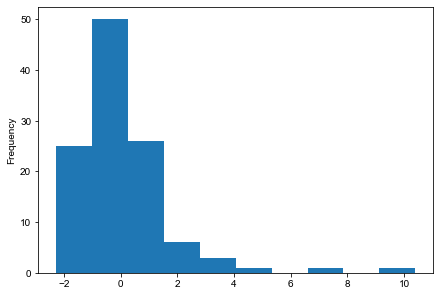

In [4]:
m1h.loc[m1h['gene_symbol'].isin(df['gene_symbol'].unique()), 'mean'].plot.hist()

<AxesSubplot: ylabel='Frequency'>

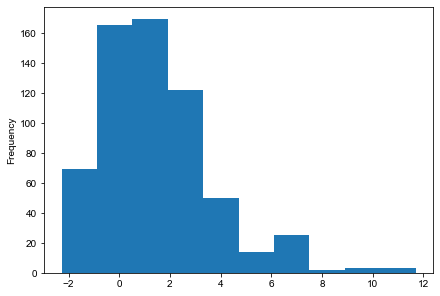

In [5]:
m1h.loc[:, 'mean'].plot.hist()

In [6]:
df['is_affected'].value_counts()

False    94
True     78
Name: is_affected, dtype: int64

In [7]:
df['complete_removal'].value_counts()

False    149
True      23
Name: complete_removal, dtype: int64

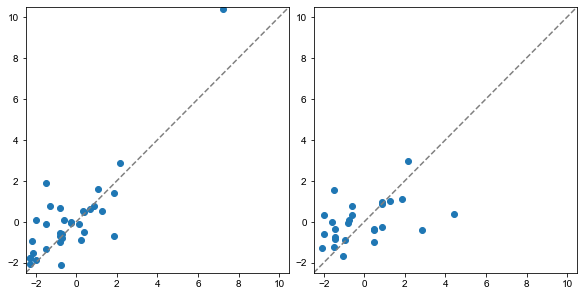

In [8]:
# scatter
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
axs[0].scatter(df.loc[~df['is_affected'], 'm1h_ref'].values,
               df.loc[~df['is_affected'], 'm1h_alt'].values)
axs[1].scatter(df.loc[df['is_affected'], 'm1h_ref'].values,
               df.loc[df['is_affected'], 'm1h_alt'].values)
for ax in axs:
    low, high = -2.5, 10.5
    ax.set_xlim(low, high)
    ax.set_ylim(low, high)
    ax.plot([low, high], [low, high], linestyle='--', color='grey')

MannwhitneyuResult(statistic=449.0, pvalue=0.922754556794691)


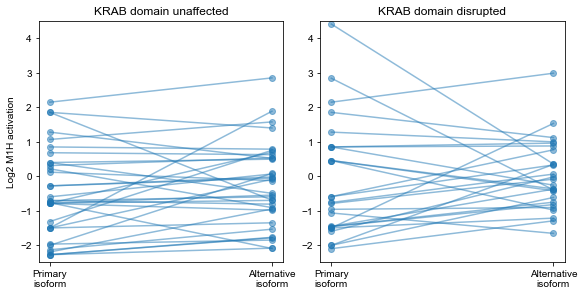

In [9]:
def pair_plot(df):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    for _i, row in df.iterrows():
        axs[int(row['is_affected'])].plot(
            [0, 1], 
            [row['m1h_ref'], row['m1h_alt']],
            'o-',
            color='C0', alpha=0.5)
    for ax in axs:
        ax.set_ylim(-2.5, 4.5)  # NOTE: this cuts off a datapoint
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Primary\nisoform', 'Alternative\nisoform'])
    axs[0].set_ylabel('Log2 M1H activation')
    axs[0].set_title('KRAB domain unaffected')
    axs[1].set_title('KRAB domain disrupted')
    a = (df.loc[~df['is_affected'], 'm1h_ref'] - df.loc[~df['is_affected'], 'm1h_alt']).values
    b = (df.loc[df['is_affected'], 'm1h_ref'] - df.loc[df['is_affected'], 'm1h_alt']).values
    print(stats.mannwhitneyu(a, b))


pair_plot(df.dropna())
plt.savefig('../figures/KRAB-affected-M1H_pairplot.pdf',
            bbox_inches='tight')

MannwhitneyuResult(statistic=141.0, pvalue=0.24548500120312422)


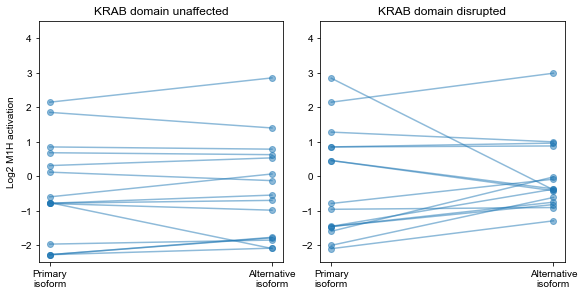

In [10]:
pair_plot(df.dropna().loc[df['n_aa_diff'] <= 100, :])
plt.savefig('../figures/KRAB-affected-M1H_less-than-100-aa-diff_pairplot.pdf',
            bbox_inches='tight')

In [11]:
# check overlap of KRAB PFam domain with manually annotated
doms = pd.read_excel('../data/internal/TF_reg_domain_2019-08-13.xlsx',
                   sheet_name='Sheet1')
doms = (doms.loc[:, ['symbol', 'Domain type', 'Domain sequence', 'aa position']]
        .rename(columns={'symbol': 'hgnc_gene_symbol',
                         'Domain type': 'type',
                         'Domain sequence': 'aa_seq',
                         'aa position': 'pos'}))
doms = doms.dropna()
doms['aa_seq'] = doms['aa_seq'].str.replace(' ', '')